# NaiveBayesCombined Age Prediction


This method is chosen as the final model to analyse due to several reasons. First, it had the highest accuracy among all models. Second, the combined model offers a level of interpretability not easily achieved with deep learning models like BERT and RoBERTa. This is crucial for understanding which features are most indicative of different age groups. Lastly, BERT and RoBERTa require large datasets to generalize effectively, making simpler models like Naive Bayes more effective when the dataset is not extremely large.

In [1]:
# import library
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import spacy
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis


## NaiveBayesCombined Model
The model code is provided by https://github.com/twistedTightly/NLP-Age-Classification/blob/master/src/naive_bayes_combined.py

In [2]:
from pos_tagger_class import pos_tagger
from naive_bayes_combined import naive_bayes_combined

df = pd.read_excel('../AgeProcessedData.xlsx')

#Set filenames
trainFilename = "../all_posts_train.txt"
testFilename = "../PosComments.txt"

#Open training file and read in lines
trainFile = open(trainFilename)
trainData = trainFile.readlines()
trainFile.close()

#Create part of speech tagger
pos_tagger = pos_tagger(trainData)

#Create tag sequence classifier
naive_bayes_combined = naive_bayes_combined(trainData)

#Set up testing data
testFile = open(testFilename)
testData = testFile.readlines()
testFile.close()

#Work through the testing data
numCorrect = 0
numIncorrect = 0
correct = 0
wordsTested = 0
linesTested = 0
predictedCategories = []  # Create a list to store predicted categories

for line in testData:
	words = line.split()
	age = words[0]
	words = words[1:]
	numWords = len(words)

	tagSequence = pos_tagger.decode(words)
	winningTag = naive_bayes_combined.decode(words, tagSequence)
	predictedCategories.append(winningTag)



In [3]:
# Add the predicted categories to the DataFrame
df['PredictedCategory'] = predictedCategories

# Save the updated DataFrame to a new Excel file
df.to_excel('../AgeProcessedDataWithPredictionsCombined.xlsx', index=False)


In [4]:
# Final clean excel file
dfWithSentiment = pd.read_excel('../RobertaSentimental.xlsx')
dfWithSentiment['PredictedCategory'] = predictedCategories
dfWithSentiment.to_excel('SentimentalAgeCombined.xlsx')

In [5]:
df = pd.read_excel('../SentimentalAgeCombined.xlsx')


### Get the top10 common words

In [6]:
# Load the English language small model of SpaCy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

# Extract positive and negative comments
positiveComments = " ".join(df[df['EmotionRoberta'] == 1]['Comment']).lower().split()
negativeComments = " ".join(df[df['EmotionRoberta'] == 0]['Comment']).lower().split()

# Remove stopwords and non-alphanumeric words using SpaCy's stopwords
positiveWords=[]
negativeWords=[]

for word in positiveComments:
    if word not in sw_spacy:
        positiveWords.append(word)

for word in negativeComments:
    if word not in sw_spacy:
        negativeWords.append(word)

# Get the most common words
positiveCount = Counter(positiveWords).most_common(10)
negativeCount = Counter(negativeWords).most_common(10)

print("Most common words in positive comments:", positiveCount)
print("Most common words in negative comments:", negativeCount)


Most common words in positive comments: [('maserati', 133), ('car', 127), ('like', 117), ('electric', 96), ('looks', 90), ('beautiful', 57), ('love', 55), ('ev', 54), ('v8', 45), ('better', 44)]
Most common words in negative comments: [('electric', 128), ('car', 125), ('maserati', 123), ('like', 105), ('cars', 64), ('ev', 55), ('looks', 54), ('sound', 52), ("it's", 51), ("don't", 46)]


### Get the top10 most common words without intersection

In [7]:
# Load the English language small model of SpaCy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

# Add "it's" to the stopwords set
sw_spacy.update(["it's", "-"])

# Extract positive and negative comments
positiveComments = " ".join(df[df['EmotionRoberta'] == 1]['Comment']).lower().split()
negativeComments = " ".join(df[df['EmotionRoberta'] == 0]['Comment']).lower().split()

# Remove stopwords and non-alphanumeric words using SpaCy's stopwords
positiveWords=[]
negativeWords=[]

for word in positiveComments:
    if word not in sw_spacy:
        positiveWords.append(word)

for word in negativeComments:
    if word not in sw_spacy:
        negativeWords.append(word)

# Get the most common words
positiveCount = Counter(positiveWords).most_common(10) #tuple ('maserati', 133),
negativeCount = Counter(negativeWords).most_common(10) 

# Extract just the words (without counts) from the common lists
positiveCountWords = set()
for word, count in positiveCount:
    positiveCountWords.add(word)

negativeCountWords= set()
for word,count in negativeCount:
    negativeCountWords.add(word)

# Identify words that are common to both positive and negative lists
intersectingWords = positiveCountWords.intersection(negativeCountWords)

# Remove the intersecting words from both lists
positiveCount = [(word, count) for word, count in positiveCount if word not in intersectingWords]
negativeCount = [(word, count) for word, count in negativeCount if word not in intersectingWords]

# Update the sets based on the cleaned common lists
positiveCountWords = set([word[0] for word in positiveCount]) #('beautiful',57)-> beautiful
negativeCountWords = set([word[0] for word in negativeCount])

# Continue extracting words from the overall most common lists
allPositiveCount = Counter(positiveWords).most_common()
allNegativeCount = Counter(negativeWords).most_common()

# Extract words from the common lists excluding those already identified
allPositiveCountWords = [word[0] for word in allPositiveCount if word[0] not in positiveCountWords]
allNegativeCountWords = [word[0] for word in allNegativeCount if word[0] not in negativeCountWords]

# Keep appending to the final lists until we have 10 unique words in each
while len(positiveCountWords) < 10:
    word = allPositiveCountWords.pop(0) #Retrieve the first element from allPositiveCountWords and remove from the list
    if word not in negativeCountWords and word not in positiveCountWords and word not in intersectingWords:
        positiveCountWords.add(word)

while len(negativeCountWords) < 10:
    word = allNegativeCountWords.pop(0)
    if word not in positiveCountWords and word not in negativeCountWords and word not in intersectingWords:
        negativeCountWords.add(word)

# Filter the lists based on the words in positiveCountWords and negativeCountWords
finalPositiveCounts = [(word, count) for word, count in allPositiveCount if word in positiveCountWords]
finalNegativeCounts = [(word, count) for word, count in allNegativeCount if word in negativeCountWords]


finalPositiveCounts, finalNegativeCounts


([('beautiful', 57),
  ('love', 55),
  ('v8', 45),
  ('better', 44),
  ('good', 40),
  ('engine', 36),
  ('design', 33),
  ('car.', 32),
  ('great', 32),
  ('new', 32)],
 [('cars', 64),
  ('sound', 52),
  ("don't", 46),
  ('old', 40),
  ('buy', 36),
  ('going', 34),
  ('know', 31),
  ('look', 30),
  ('petrol', 29),
  ('battery', 24)])

## Plot the Graphs

### Distribution of Sentimental Analysis

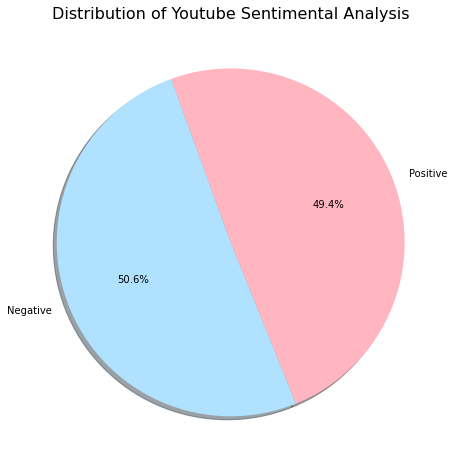

In [8]:
# Calculate the distribution for EmotionRoberta
emotionCounts = df['EmotionRoberta'].value_counts()
emotionCounts
# Plot a pie chart
plt.figure(figsize=(8, 8))
colors = ["#B0E2FF","#FFB6C1"]
labels = ['Negative','Positive']
# explode = (0.1, 0)  # explode 1st slice for better visibility
plt.pie(emotionCounts, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=110)
plt.title('Distribution of Youtube Sentimental Analysis',fontsize=16)
plt.show()


### Distribution of Predicted Category

/Users/jocelyn/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/jocelyn/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


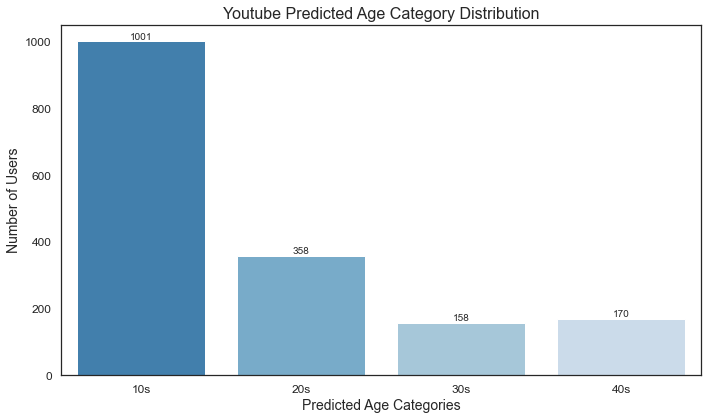

In [9]:
# Set seaborn style
sns.set(style="white")

# Count the occurrences of each predicted category
categoryCounts = df['PredictedCategory'].value_counts()


# Sort the category_counts Series by index
sortedCategory = categoryCounts.sort_index()

# Create a bar plot using seaborn with x-labels and y-values sorted
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sortedCategory.index.astype(str) + 's', y=sortedCategory.values, palette="tab20c")


# Add labels and title
plt.xlabel('Predicted Age Categories', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.title('Youtube Predicted Age Category Distribution', fontsize=16)


# Rotate x labels for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add data labels on the bars
for index, value in enumerate(sortedCategory.values):
    plt.text(index, value + 1, str(value), ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


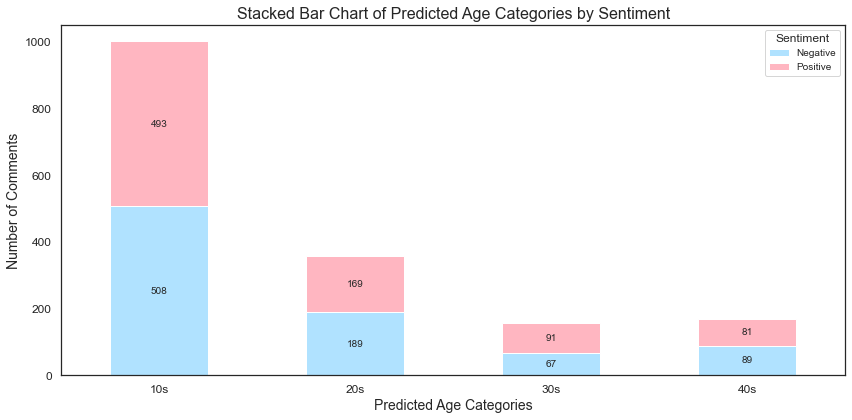

In [10]:
# Create a crosstab between PredictedCategory and EmotionRoberta
crosstabData= pd.crosstab(df['PredictedCategory'],df['EmotionRoberta'])

# Plot the stacked bar chart
ax = crosstabData.plot(kind='bar',stacked=True,figsize=(12, 6), color=["#B0E2FF","#FFB6C1"])


# Style and label the plot
plt.title('Stacked Bar Chart of Predicted Age Categories by Sentiment', fontsize=16)
plt.xlabel('Predicted Age Categories',fontsize=14)
plt.ylabel('Number of Comments',fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='Sentiment', labels=['Negative', 'Positive'], fontsize=10)

# Add the emotion counts to the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # To avoid placing labels on bars with height 0
        ax.text(x + width/2, y + height/2, str(int(height)), ha='center', va='center', fontsize=10)

# Update x-axis labels to add 's'
ax.set_xticklabels([str(int(label)) + 's' for label in crosstabData.index])
plt.tight_layout()
plt.show()

### Top 10 words for positive and negative comments 

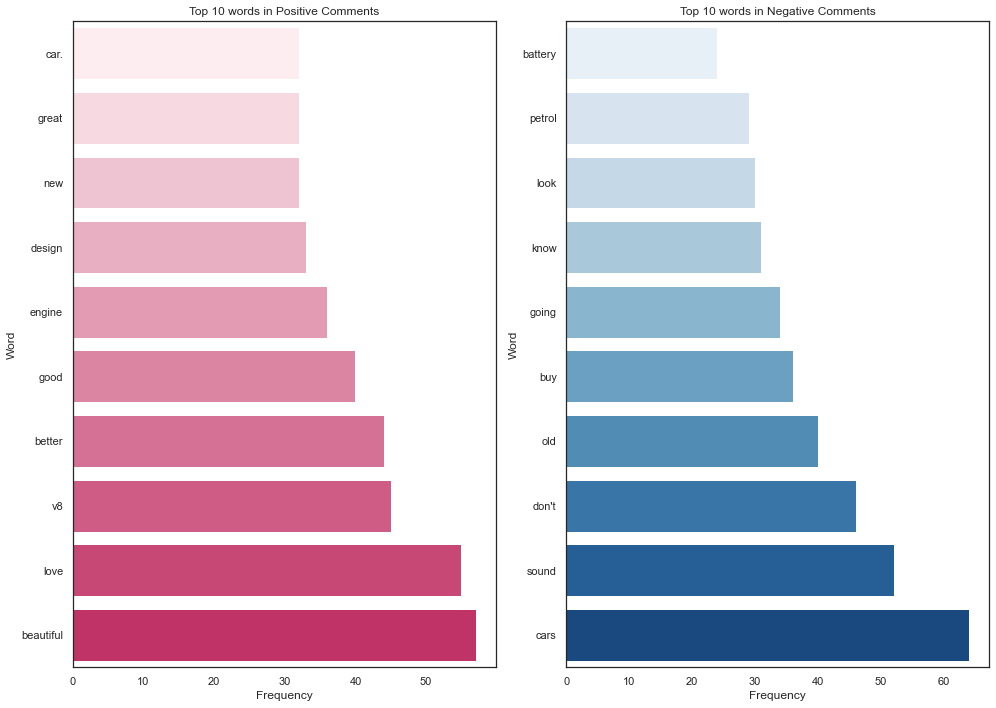

In [11]:
import seaborn as sns
import pandas as pd

# Convert the dictionaries to DataFrames
dfPositive = pd.DataFrame(finalPositiveCounts, columns=['Word', 'Frequency'])
dfNegative = pd.DataFrame(finalNegativeCounts, columns=['Word', 'Frequency'])

# Sort the data for better visualization
dfPositive = dfPositive.sort_values(by='Frequency')
dfNegative = dfNegative.sort_values(by='Frequency')

plt.figure(figsize=(14, 10))

pink_shades = sns.blend_palette(["#FFEBEE", "#D81B60"], n_colors=10)

# Plot for Positive Comments
plt.subplot(1, 2, 1)
sns.set_palette(pink_shades)

sns.barplot(data=dfPositive, y='Word', x='Frequency')
plt.title('Top 10 words in Positive Comments')

# Plot for Negative Comments
plt.subplot(1, 2, 2)
sns.barplot(data=dfNegative, y='Word', x='Frequency', palette="Blues")
plt.title('Top 10 words in Negative Comments')

plt.tight_layout()
plt.show()
